In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
import time
import os
from scipy.stats import gamma
from scipy.special import erf, gammaincinv
from IPython.display import Markdown, display

# Import Data

In [2]:
start_time = time.time()

# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

/var/tmp/stamou/ipykernel_773357/911792637.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


⏱️ Execution time: 1.18 seconds


# Original |Cut-off scale: $z=0.15$

In [6]:
import emcee
import numpy as np
import multiprocessing

# --- Priors ---
priors_cosmo = {
    'M': (-20.0, -19.0),
    'H0': (65.0, 78.0),
    'q0': (-1.0, 0.0)
}


def dL_cosmography(z, H0, q0):
    return (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)

def mu_theory_notransition(z_array, H0, q0):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), H0, q0)) + 25
        for z in z_array
    ])

def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, q0 = params
    mu_model = mu_theory_notransition(z, H0, q0)

    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M - mu_model)
    )

    return Q.T @ C_inv @ Q


def log_posterior_cosmo(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    M, H0, q0 = params

    # Unpack prior bounds
    M_min, M_max = priors['M']
    H0_min, H0_max = priors['H0']
    q0_min, q0_max = priors['q0']

    # Flat priors with hard bounds
    if not (M_min <= M <= M_max and H0_min <= H0 <= H0_max and q0_min <= q0 <= q0_max):
        return -np.inf

    chi2_val = chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2_val

In [4]:
import time
import numpy as np
import emcee
import multiprocessing
import pickle
# --- Run with timing ---
start_time = time.time()

def run_emcee_cosmography(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
                          n_walkers=32, n_steps=5000, burn_in=1000):
    
    ndim = 3  # Parameters: M, H0, q0

    # --- Initialize walkers ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['q0'])
        ]
        for _ in range(n_walkers)
    ])

    # --- Multiprocessing pool ---
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior_cosmo,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )

        # --- Run MCMC ---
        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Flattened samples after burn-in ---
    samples = sampler.get_chain(discard=burn_in, flat=True)

    # ✅ Save chains
    np.save("samples_cosmography_notransition_5000steps.npy", samples)
    np.save("full_chain_cosmography_notransition.npy", sampler.get_chain())
    # ✅ Save full sampler via pickle
    with open("sampler_cosmography_notransition.pkl", "wb") as f:
        pickle.dump(sampler, f)

    return samples, sampler

# --- Execute ---
samples_cosmo, sampler_cosmo = run_emcee_cosmography(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors_cosmo,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


100%|█████████████████████████████████████| 5000/5000 [2:58:41<00:00,  2.14s/it]


⏱️ Execution time: 10725.41 seconds


In [8]:
with open("Saved Samples/sampler_cosmography_notransition.pkl", "rb") as f:
    sampler = pickle.load(f)

# Compute autocorrelation time
try:
    tau = sampler.get_autocorr_time()
    print("Autocorrelation time (in steps) per parameter:")
    for i, t in enumerate(tau):
        print(f"  Param {i}: τ = {t:.1f}")

    # Compute effective sample size (ESS)
    n_walkers, n_steps, n_dim = sampler.get_chain().shape
    ess = n_walkers * n_steps / tau
    print("\nEstimated effective sample size (ESS):")
    for i, e in enumerate(ess):
        print(f"  Param {i}: ESS ≈ {e:.0f}")

except emcee.autocorr.AutocorrError as e:
    print("Warning: Autocorrelation time could not be reliably estimated.")
    print("Reason:", str(e))


Autocorrelation time (in steps) per parameter:
  Param 0: τ = 36.9
  Param 1: τ = 38.0
  Param 2: τ = 36.3

Estimated effective sample size (ESS):
  Param 0: ESS ≈ 4330
  Param 1: ESS ≈ 4216
  Param 2: ESS ≈ 4413


In [3]:
import pickle
import numpy as np

# Load the sampler
with open("Saved Samples/sampler_cosmography_notransition.pkl", "rb") as f:
    sampler = pickle.load(f)

# Get samples and log-probabilities
burn_in = 1000
samples = sampler.get_chain(discard=burn_in, flat=True)
log_probs = sampler.get_log_prob(discard=burn_in, flat=True)

# Parameter names
param_names = ["M", "H0", "q0"]

# Compute MAP estimate
map_idx = np.argmax(log_probs)
theta_map = samples[map_idx]

# Compute median, mean, and 1σ intervals
medians = np.median(samples, axis=0)
means = np.mean(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)
sigma_minus = medians - lower
sigma_plus = upper - medians

# Print all results
print(f"{'Parameter':<8} {'MAP':>10} {'Median':>10} {'Mean':>10} {'+σ':>10} {'-σ':>10}")
print("-" * 58)
for i, name in enumerate(param_names):
    print(f"{name:<8} {theta_map[i]:10.5f} {medians[i]:10.5f} {means[i]:10.5f} "
          f"{sigma_plus[i]:10.5f} {sigma_minus[i]:10.5f}")

Parameter        MAP     Median       Mean         +σ         -σ
----------------------------------------------------------
M         -19.24939  -19.24848  -19.24845    0.02908    0.02894
H0         73.09066   73.14376   73.15599    1.03676    1.00805
q0         -0.38086   -0.39024   -0.39249    0.15795    0.15889


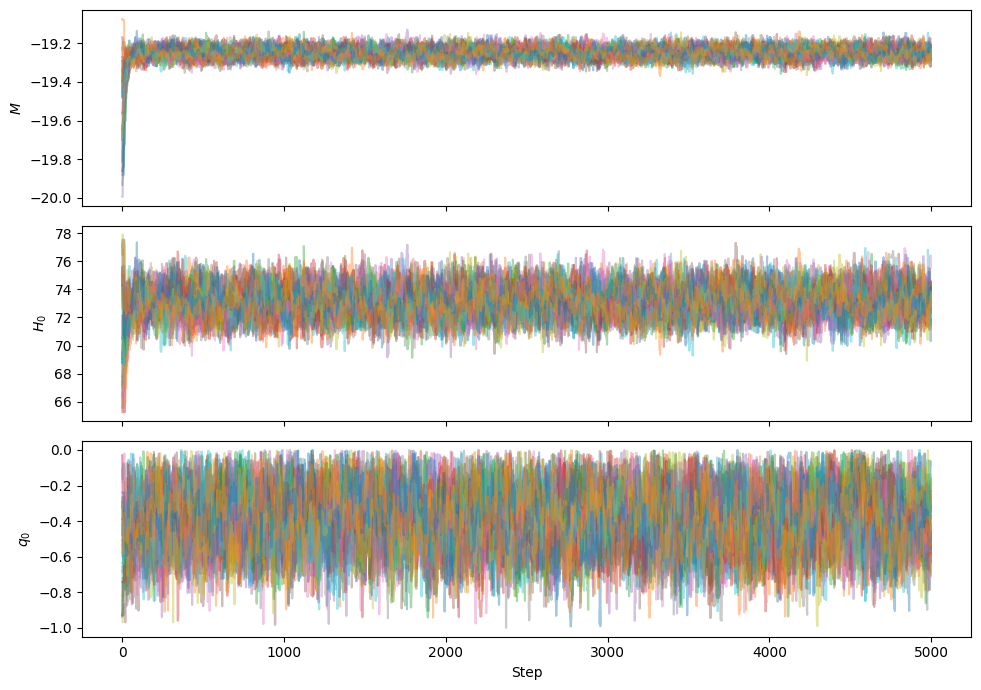

In [5]:
# Load the samples
samples = np.load("samples_cosmography_notransition_5000steps.npy")
full_chain = np.load("full_chain_cosmography_notransition.npy")

# Parameter labels for cosmography
param_labels = [r"$M$", r"$H_0$", r"$q_0$"]

# Plotting the chain
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

for i in range(3):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])

axes[-1].set_xlabel("Step")
plt.tight_layout()

# Save the figure
fig.savefig("chain_plot_cosmography_notransition.png", dpi=300)
plt.show()

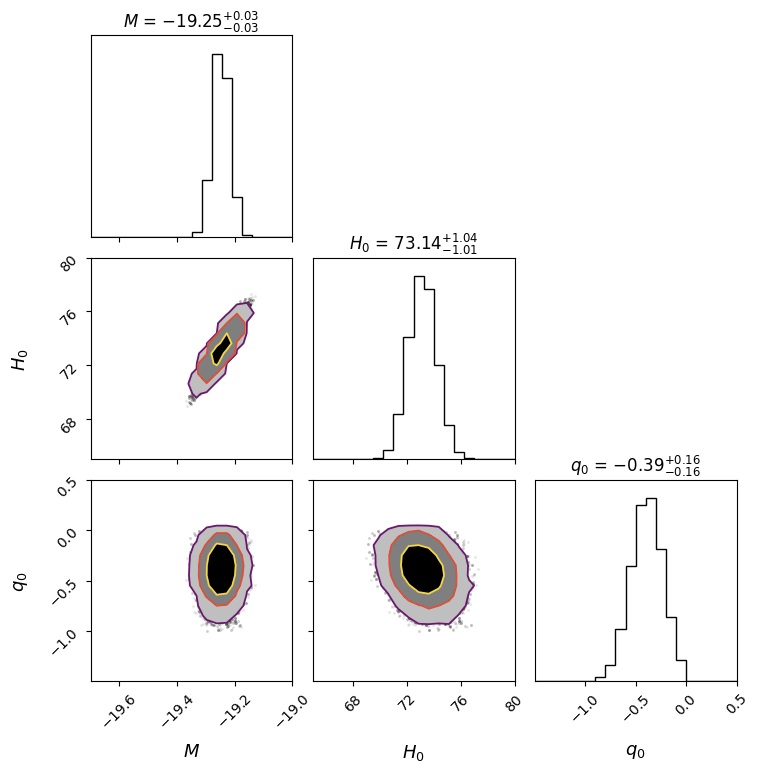

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from IPython.display import display, Math

# Load samples
samples = np.load("samples_cosmography_notransition_5000steps.npy")
param_labels = [r"$M$", r"$H_0$", r"$q_0$"]

# Define credible levels
levels = [0.68, 0.95, 0.997]
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# Define axis ranges
ranges = [
    (-19.7, -19.0),  # M
    (65, 80),        # H0
    (-1.5, 0.5)      # q0
]

# Generate corner plot
fig_cosmo = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

# Tidy up spacing
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# Save plot
fig_cosmo.savefig("corner_plot_cosmography_notransition.png", dpi=300)
plt.show()


In [7]:
# Parameter labels (LaTeX) and units
param_labels = [r"M", r"H_0", r"q_0"]
units = ["", r"\,\mathrm{km/s/Mpc}", ""]

# Compute median and 68% CI
medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

# Display in LaTeX format
display(Math(r"\textbf{Posterior medians with 68\% credible intervals:}"))
for label, med, low, up, unit in zip(param_labels, medians, lower, upper, units):
    err_minus = med - low
    err_plus = up - med
    display(Math(rf"{label} = {med:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{unit}"))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Transition in $M$ |Cut-off scale: $z=0.15$

In [10]:
# --- Chi-square with transition model (cosmography, z < 0.15 only) ---
def chi2_cosmo_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0_tr, q0_tr, d_crit = params

    mu_model = mu_theory_notransition(z, H0_tr, q0_tr)
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M_used - mu_model)
    )

    return Q.T @ C_inv @ Q


priors_cosmo_transition = {
    'M_low': (-20.0, -18.0),
    'M_high': (-20.0, -18.0),
    'H0': (65.0, 78.0),
    'q0': (-1.0, 0.0),
    'd_crit': (15.0, 25.0)
}

def log_posterior_cosmo_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    """
    Compute log-posterior for cosmography model with M transition.
    """
    # Unpack prior bounds and check validity
    for val, (low, high) in zip(params, priors.values()):
        if not (low <= val <= high):
            return -np.inf

    chi2_val = chi2_cosmo_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2_val


In [8]:
import emcee
import numpy as np
import multiprocessing
import time

start_time = time.time()

def run_emcee_cosmo_transition(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
                                n_walkers=32, n_steps=5000, burn_in=1000):
    """
    Run emcee sampler for cosmography model with a transition in M.
    """
    ndim = 5  # Parameters: M_low, M_high, H0, q0, d_crit

    # Initialize walkers uniformly within prior bounds
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M_low']),
            np.random.uniform(*priors['M_high']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['q0']),
            np.random.uniform(*priors['d_crit'])
        ]
        for _ in range(n_walkers)
    ])

    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior_cosmo_transition,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )
        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    samples = sampler.get_chain(discard=burn_in, flat=True)

    # Save for reuse
    np.save("samples_cosmo_transition_5000steps.npy", samples)
    np.save("full_chain_cosmo_transition.npy", sampler.get_chain())
    # ✅ Save full sampler via pickle
    with open("sampler_cosmography_transition.pkl", "wb") as f:
        pickle.dump(sampler, f)    

    return samples, sampler

samples_cosmo_transition, sampler_cosmo_transition = run_emcee_cosmo_transition(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors_cosmo_transition,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

100%|█████████████████████████████████████| 5000/5000 [2:57:50<00:00,  2.13s/it]


⏱️ Execution time: 10674.55 seconds


In [11]:
import numpy as np
import pickle

# --- Load samples and sampler ---
samples = np.load("samples_cosmo_transition_5000steps.npy")
with open("sampler_cosmography_transition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Get log-probabilities and MAP ---
log_prob = sampler.get_log_prob(discard=1000, flat=True)
map_index = np.argmax(log_prob)
map_params = samples[map_index]

# --- Compute statistics ---
medians = np.median(samples, axis=0)
means = np.mean(samples, axis=0)
lower_bounds = np.percentile(samples, 16, axis=0)
upper_bounds = np.percentile(samples, 84, axis=0)
errors_minus = medians - lower_bounds
errors_plus = upper_bounds - medians

# --- Parameter names ---
param_names = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$q_0$", r"$d_{\rm crit}$"]

# --- Print all results ---
print(f"{'Parameter':<12} {'MAP':>10} {'Median':>10} {'Mean':>10} {'+σ':>10} {'-σ':>10}")
print("-" * 60)
for i, name in enumerate(param_names):
    print(f"{name:<12} {map_params[i]:10.5f} {medians[i]:10.5f} {means[i]:10.5f} "
          f"{errors_plus[i]:10.5f} {errors_minus[i]:10.5f}")


Parameter           MAP     Median       Mean         +σ         -σ
------------------------------------------------------------
$M_{<}$       -19.39856  -19.40447  -19.40538    0.05405    0.05618
$M_{>}$       -19.20494  -19.21183  -19.21206    0.03105    0.03163
$H_0$          74.59535   74.37178   74.38157    1.13453    1.11824
$q_0$          -0.37377   -0.38858   -0.39223    0.15523    0.16307
$d_{\rm crit}$   19.95479   19.62551   19.81150    1.17993    0.76687


In [12]:
import pickle
import numpy as np
import emcee

# --- Load the saved sampler ---
with open("sampler_cosmography_transition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Compute autocorrelation time ---
try:
    tau = sampler.get_autocorr_time()
    print("Autocorrelation time (in steps) per parameter:")
    for i, t in enumerate(tau):
        print(f"  Param {i}: τ = {t:.1f}")

    # --- Compute effective sample size (ESS) ---
    n_walkers, n_steps, n_dim = sampler.get_chain().shape
    ess = n_walkers * n_steps / tau
    print("\nEstimated effective sample size (ESS):")
    for i, e in enumerate(ess):
        print(f"  Param {i}: ESS ≈ {e:.0f}")

except emcee.autocorr.AutocorrError as e:
    print("⚠️ Autocorrelation time could not be reliably estimated.")
    print("Reason:", str(e))


Autocorrelation time (in steps) per parameter:
  Param 0: τ = 58.0
  Param 1: τ = 57.9
  Param 2: τ = 65.0
  Param 3: τ = 60.8
  Param 4: τ = 76.6

Estimated effective sample size (ESS):
  Param 0: ESS ≈ 2757
  Param 1: ESS ≈ 2765
  Param 2: ESS ≈ 2461
  Param 3: ESS ≈ 2633
  Param 4: ESS ≈ 2089


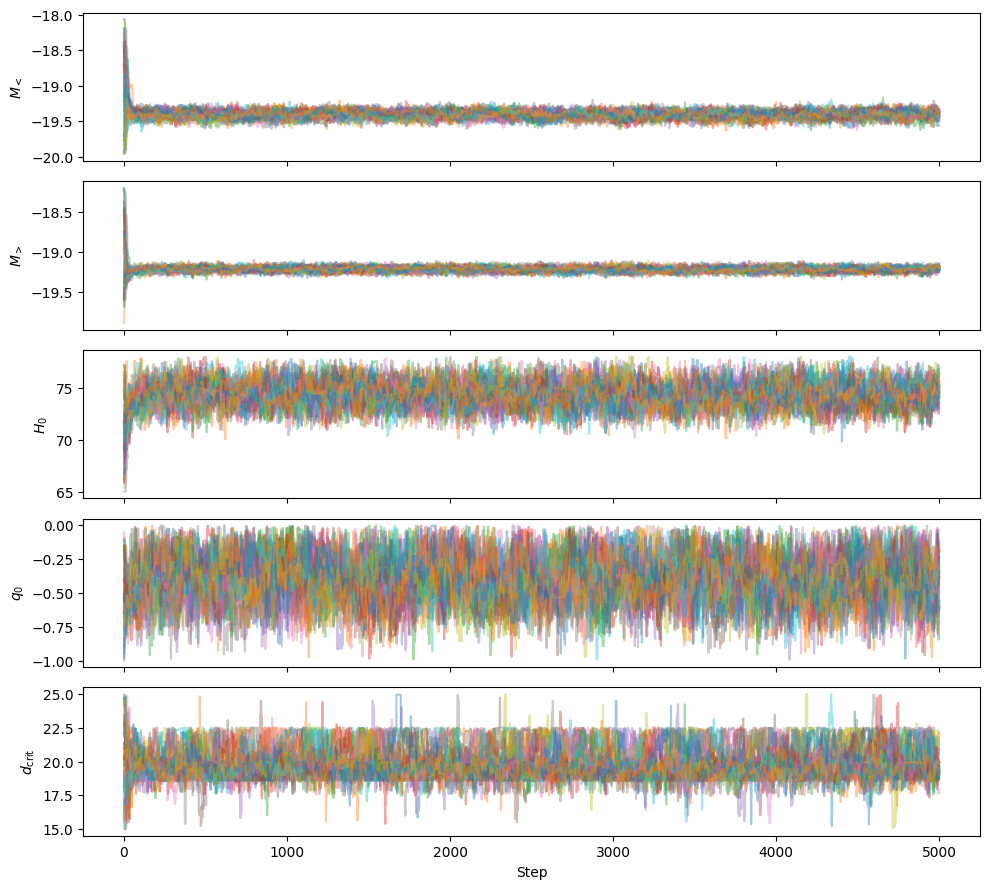

In [7]:
# Load the samples and full chain for the transition case
samples = np.load("samples_cosmo_transition_5000steps.npy")
full_chain = np.load("full_chain_cosmo_transition.npy")

# Parameter labels for the transition model
param_labels = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$q_0$", r"$d_{\mathrm{crit}}$"]

# Create the chain plot
fig, axes = plt.subplots(5, figsize=(10, 9), sharex=True)

for i in range(5):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])

axes[-1].set_xlabel("Step")
plt.tight_layout()

# Save the figure
fig.savefig("chain_plot_cosmography_transition.png", dpi=300)
plt.show()


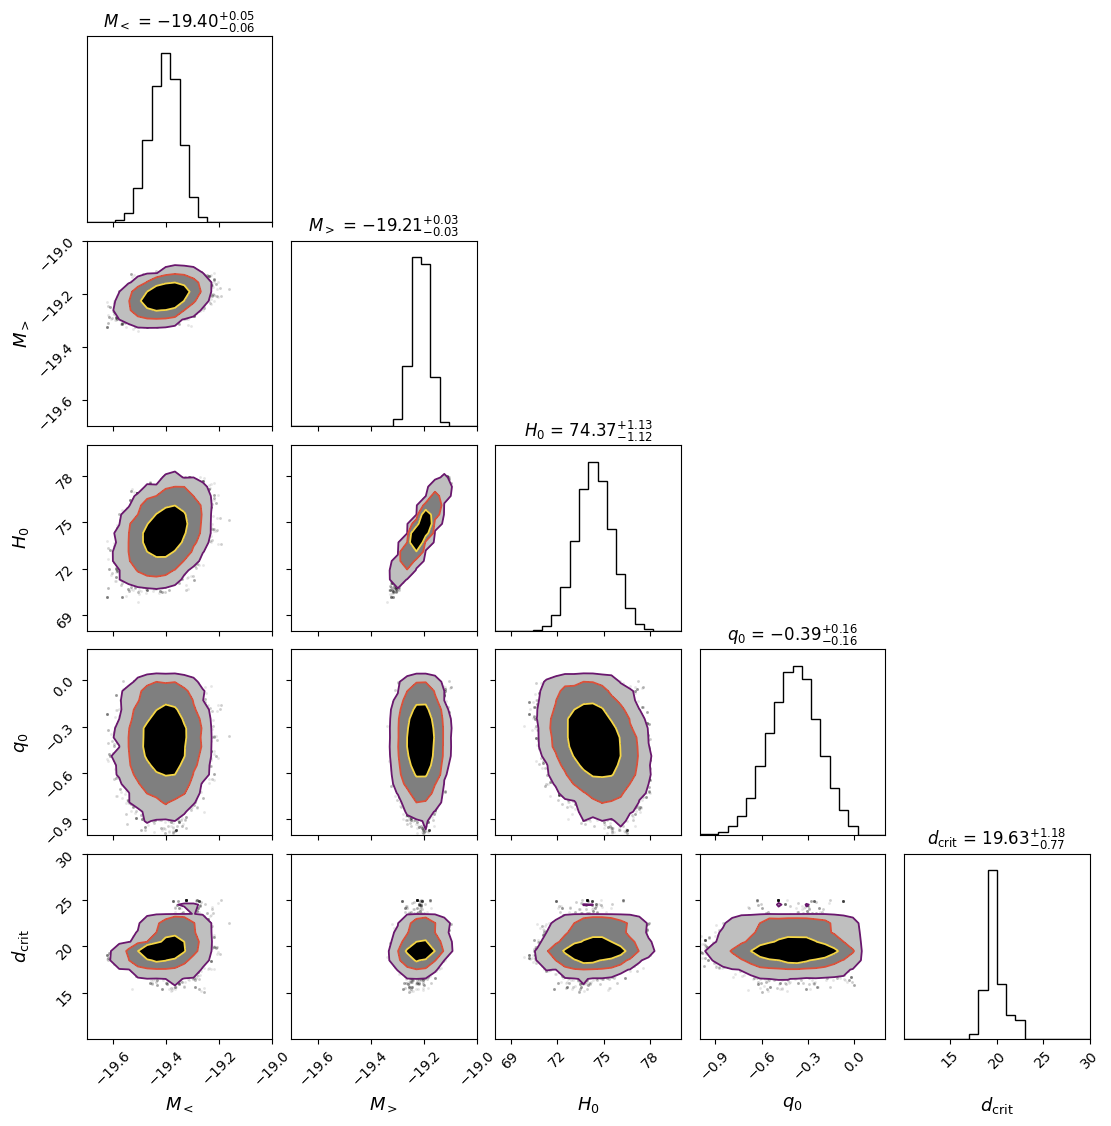

In [8]:
import corner

# Load transition samples
samples = np.load("samples_cosmo_transition_5000steps.npy")

# Parameter labels for the transition model
param_labels = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$q_0$", r"$d_{\mathrm{crit}}$"]

# Define credible levels and color map
levels = [0.68, 0.95, 0.997]
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# Define axis ranges for visual clarity
ranges = [
    (-19.7, -19.0),  # M_low
    (-19.7, -19.0),  # M_high
    (68, 80),        # H0
    (-1.0, 0.2),    # q0
    (10.0, 30.0)     # d_crit
]

# Generate the corner plot
fig_corner = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

# Adjust layout and save
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)
fig_corner.savefig("corner_plot_cosmography_transition.png", dpi=300)
plt.show()

# Nested Sampling & dynesty sampler 

## Original |Cut-off scale: $z=0.15$

In [5]:
priors_cosmo = {
    'M': (-20.0, -19.0),
    'H0': (65.0, 78.0),
    'q0': (-1.0, 0.0)
}
def prior_transform_cosmo(u):
    """
    Maps unit cube [0,1]^3 → physical parameters for cosmography model
    """
    M_min, M_max = priors_cosmo['M']
    H0_min, H0_max = priors_cosmo['H0']
    q0_min, q0_max = priors_cosmo['q0']
    
    M = M_min + u[0] * (M_max - M_min)
    H0 = H0_min + u[1] * (H0_max - H0_min)
    q0 = q0_min + u[2] * (q0_max - q0_min)
    
    return [M, H0, q0]
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, q0 = params
    mu_model = mu_theory_notransition(z, H0, q0)

    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M - mu_model)
    )

    return Q.T @ C_inv @ Q
def log_likelihood_cosmo(theta):
    """
    Dynesty-compatible log-likelihood = -0.5 * chi²
    """
    M, H0, q0 = theta
    chi2 = chi2_notransition([M, H0, q0], z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2


In [6]:
import dynesty
import multiprocessing

# Number of parameters: M, H0, q0
ndim = 3

# Enable multiprocessing for nested sampling
with multiprocessing.Pool() as pool:
    dsampler_cosmo = dynesty.NestedSampler(
        log_likelihood_cosmo,        # Your cosmography likelihood
        prior_transform_cosmo,       # Your prior transform
        ndim=ndim,
        nlive=500,                   # Number of live points
        sample='rwalk',
        bound='multi',
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler_cosmo.run_nested(print_progress=True)
    results_cosmo = dsampler_cosmo.results


3730it [08:30,  7.31it/s, +500 | bound: 23 | nc: 1 | ncall: 67492 | eff(%):  6.314 | loglstar:   -inf < -374.233 <    inf | logz: -380.906 +/-  0.110 | dlogz:  0.001 >  0.509]


In [20]:
# Extract raw samples and weights
samples_no = results_cosmo.samples
logwt_no = results_cosmo.logwt
logz_no = results_cosmo.logz[-1]

# Compute normalized weights
weights_no = np.exp(logwt_no - logz_no)
weights_no /= np.sum(weights_no)

# Resample posterior with equal weights
posterior_samples_no = dyfunc.resample_equal(samples_no, weights_no)

# Save for later use
np.save("posterior_samples_cosmography_no_transition.npy", posterior_samples_no)

# Print log-evidence and uncertainty
logZ_no = results_cosmo.logz[-1]
logZerr_no = results_cosmo.logzerr[-1]

print(f"logZ (cosmography no transition): {logZ_no:.2f} ± {logZerr_no:.2f}")

logZ (cosmography no transition): -380.91 ± 0.20


In [13]:
# Extract log-weights
logwt = results_cosmo.logwt
logz = results_cosmo.logz[-1]

# Compute normalized weights
weights = np.exp(logwt - logz)
weights /= np.sum(weights)  # make sure they sum to 1

# Compute Effective Sample Size (ESS)
ess = 1.0 / np.sum(weights**2)
print(f"Effective Sample Size (ESS): {ess:.1f}")


Effective Sample Size (ESS): 1817.2


In [7]:
import numpy as np

# Extract samples and log-likelihoods from dynesty results
samples = results_cosmo.samples
logl = results_cosmo.logl

# MAP: point with max log-likelihood
map_idx = np.argmax(logl)
map_params = samples[map_idx]

# Medians and 68% credible intervals
medians = np.median(samples, axis=0)
lowers = np.percentile(samples, 16, axis=0)
uppers = np.percentile(samples, 84, axis=0)
minus_sigma = medians - lowers
plus_sigma = uppers - medians

# Parameter names
param_names = ["M", "H0", "q0"]
units = ["", "km/s/Mpc", ""]

print("Parameter       MAP Value       Median ± 1σ       Unit")
print("----------------------------------------------------------")
for name, map_val, med, minus, plus, unit in zip(param_names, map_params, medians, minus_sigma, plus_sigma, units):
    print(f"{name:<15} {map_val:>10.4f}   {med:.4f} +{plus:.4f} -{minus:.4f}   {unit}")


Parameter       MAP Value       Median ± 1σ       Unit
----------------------------------------------------------
M                 -19.2508   -19.2586 +0.0626 -0.1549   
H0                 73.0364   72.8975 +2.1088 -3.4086   km/s/Mpc
q0                 -0.3748   -0.4280 +0.2330 -0.3076   


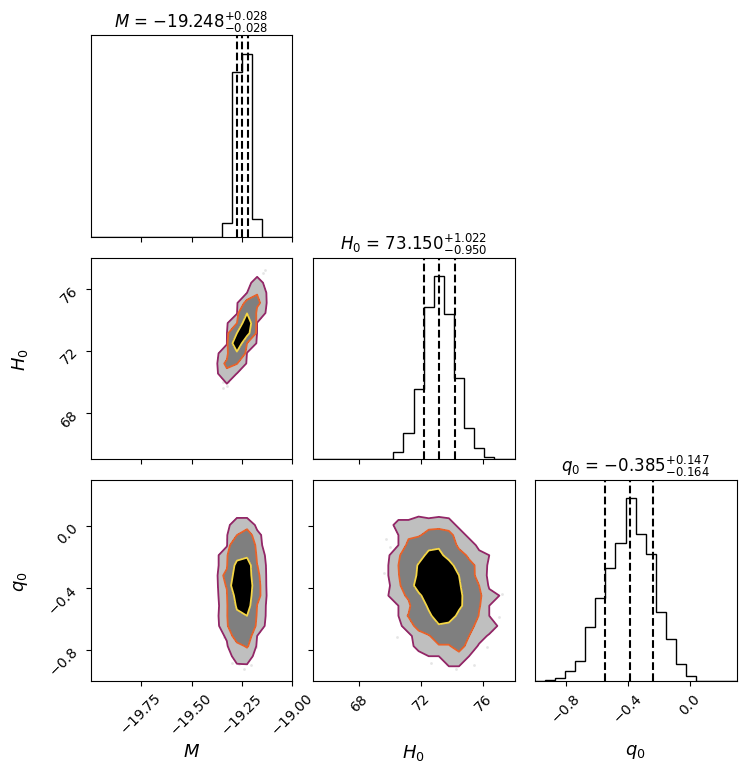

In [9]:
import matplotlib.pyplot as plt
import corner
from dynesty import utils as dyfunc

# Get posterior-weighted samples
weights = np.exp(results_cosmo.logwt - results_cosmo.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)

# Save if desired
np.save("posterior_samples_cosmography.npy", posterior_samples)

# Define parameter labels
param_labels = [r"$M$", r"$H_0$", r"$q_0$"]
ranges = [(-20.0, -19.0), (65, 78), (-1.0, 0.3)]
levels = [0.68, 0.95, 0.997]
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.4, 0.9, len(levels))]

# Create corner plot
fig = corner.corner(
    posterior_samples,
    labels=param_labels,
    range=ranges,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    levels=levels,
    fill_contours=True,
    plot_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12}
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)
fig.savefig("corner_cosmography_q0.png", dpi=300)
plt.show()


## Transition in $M$ |Cut-off scale: $z=0.15$

In [10]:
def prior_transform_cosmo_transition(u):
    """
    Maps unit cube [0,1]^5 → physical parameters for cosmography + M transition
    """
    keys = list(priors_cosmo_transition.keys())
    return [
        priors_cosmo_transition[k][0] + u[i] * (priors_cosmo_transition[k][1] - priors_cosmo_transition[k][0])
        for i, k in enumerate(keys)
    ]

def log_likelihood_cosmo_transition(theta):
    """
    Log-likelihood for cosmography with M transition
    """
    chi2 = chi2_cosmo_transition(theta, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2


In [14]:
ndim = 5  # M_low, M_high, H0, q0, d_crit

with multiprocessing.Pool() as pool:
    dsampler_cosmo_trans = dynesty.NestedSampler(
        log_likelihood_cosmo_transition,
        prior_transform_cosmo_transition,
        ndim=ndim,
        nlive=500,
        sample='rwalk',
        bound='multi',
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler_cosmo_trans.run_nested(print_progress=True)
    results_cosmo_transition = dsampler_cosmo_trans.results

6921it [18:05,  6.38it/s, +500 | bound: 59 | nc: 1 | ncall: 158764 | eff(%):  4.689 | loglstar:   -inf < -364.193 <    inf | logz: -377.489 +/-  0.164 | dlogz:  0.001 >  0.509]


In [15]:
# Extract log-weights and log-evidence
logwt_trans = results_cosmo_transition.logwt
logz_trans = results_cosmo_transition.logz[-1]

# Compute normalized weights
weights_trans = np.exp(logwt_trans - logz_trans)
weights_trans /= np.sum(weights_trans)

# Compute Effective Sample Size
ess_trans = 1.0 / np.sum(weights_trans**2)
print(f"Effective Sample Size (ESS) [Transition]: {ess_trans:.1f}")


Effective Sample Size (ESS) [Transition]: 2979.6


In [16]:
# Extract samples and log-likelihoods
samples = results_cosmo_transition.samples
logl = results_cosmo_transition.logl

# MAP (maximum likelihood point)
map_idx = np.argmax(logl)
map_params = samples[map_idx]

# Median and 68% credible intervals
medians = np.median(samples, axis=0)
lowers = np.percentile(samples, 16, axis=0)
uppers = np.percentile(samples, 84, axis=0)
minus_sigma = medians - lowers
plus_sigma = uppers - medians

# Parameter names and units
param_names = ["M_low", "M_high", "H0", "q0", "d_crit"]
units = ["", "", "km/s/Mpc", "", "Mpc"]

print("Parameter         MAP Value       Median ± 1σ         Unit")
print("---------------------------------------------------------------")
for name, map_val, med, minus, plus, unit in zip(param_names, map_params, medians, minus_sigma, plus_sigma, units):
    print(f"{name:<17} {map_val:>10.4f}   {med:.4f} +{plus:.4f} -{minus:.4f}   {unit}")


Parameter         MAP Value       Median ± 1σ         Unit
---------------------------------------------------------------
M_low               -19.3964   -19.3947 +0.2786 -0.1097   
M_high              -19.1979   -19.2208 +0.0608 -0.1054   
H0                   74.8129   73.9638 +1.7585 -3.3796   km/s/Mpc
q0                   -0.3635   -0.4208 +0.2201 -0.2807   
d_crit               19.9551   19.4532 +2.4061 -1.8320   Mpc


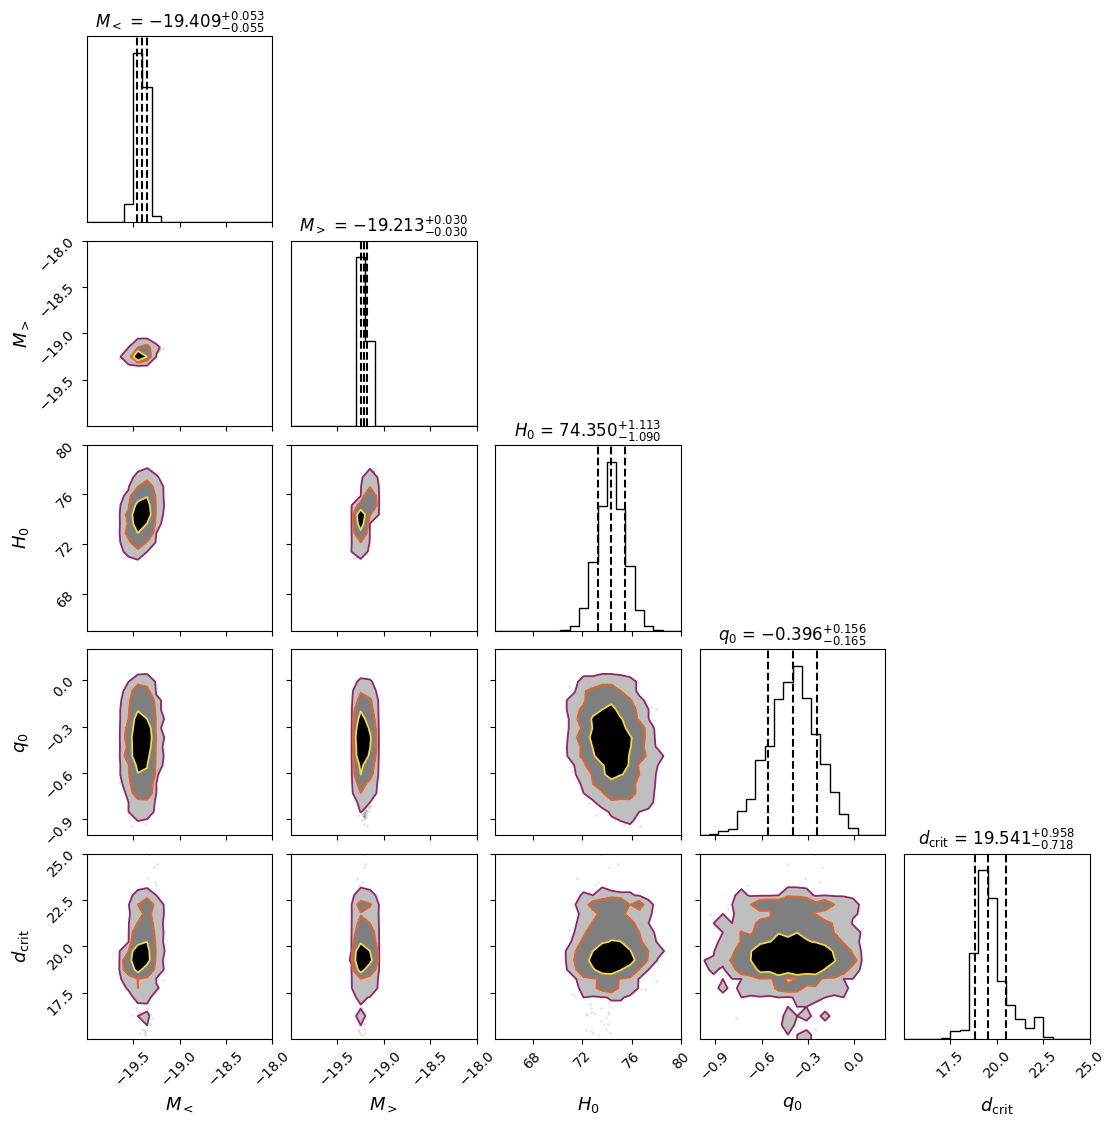

In [18]:
import matplotlib.pyplot as plt
import corner
from dynesty import utils as dyfunc

# Resample posterior
weights = np.exp(results_cosmo_transition.logwt - results_cosmo_transition.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)

# Save if needed
np.save("posterior_samples_cosmo_transition.npy", posterior_samples)

# Labels and ranges
param_labels = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$q_0$", r"$d_{\rm crit}$"]
ranges = [(-20.0, -18.0), (-20.0, -18.0), (65, 80), (-1.0, 0.2), (15, 25)]
levels = [0.68, 0.95, 0.997]
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.4, 0.9, len(levels))]

# Corner plot
fig = corner.corner(
    posterior_samples,
    labels=param_labels,
    range=ranges,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    levels=levels,
    fill_contours=True,
    plot_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12}
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)
fig.savefig("corner_cosmography_transition.png", dpi=300)
plt.show()


In [19]:
logZ = results_cosmo_transition.logz[-1]
logZerr = results_cosmo_transition.logzerr[-1]
print(f"logZ (cosmography with M transition): {logZ:.2f} ± {logZerr:.2f}")


logZ (cosmography with M transition): -377.49 ± 0.25


# Model Comparison

In [24]:
# Compute ΔlogZ and uncertainty
delta_logZ = logZ - logZ_no
delta_logZ_err = np.sqrt(logZerr**2 + logZerr_no**2)

# Print result
print("Bayesian Model Comparison (Cosmography):")
print("-----------------------------------------")
print(f"logZ (No Transition)     = {logZ_no:.2f} ± {logZerr_no:.2f}")
print(f"logZ (With Transition)   = {logZ:.2f} ± {logZerr:.2f}")
print(f"ΔlogZ (Transition - No)  = {delta_logZ:.2f} ± {delta_logZ_err:.2f}")

# Jeffreys' scale interpretation
if delta_logZ < 1:
    interpretation = "Inconclusive preference"
elif delta_logZ < 2.5:
    interpretation = "Weak evidence for transition model"
elif delta_logZ < 5:
    interpretation = "Moderate evidence for transition model"
else:
    interpretation = "Strong evidence for transition model"

print(f"Interpretation: {interpretation}")

# Optional: compute Bayes Factor
bayes_factor = np.exp(delta_logZ)
print(f"Bayes Factor (Transition / No) = {bayes_factor:.2f}")


Bayesian Model Comparison (Cosmography):
-----------------------------------------
logZ (No Transition)     = -380.91 ± 0.20
logZ (With Transition)   = -377.49 ± 0.25
ΔlogZ (Transition - No)  = 3.42 ± 0.32
Interpretation: Moderate evidence for transition model
Bayes Factor (Transition / No) = 30.49
